# Mixture of Experts (MoE) for Linear Regression

In this notebook, we will explore how to use the Mixture of Experts (MoE) framework to fit pre-trained 
linear models to a simple 1 dimensional dataset. We will compare the MoE model to a simple linear model 
that follows the `MultiPRS` framework (i.e. use all pre-trained models as covariates). 

To start, let's import the necessary libraries and modules that will be needed for this notebook.


In [28]:
import numpy as np
import pandas as pd
import sys
sys.path.append("../model/")
from PRSDataset import PRSDataset
from moe import MoEPRS
from baseline_models import MultiPRS
import matplotlib.pyplot as plt
import seaborn as sns

## The Data

After importing the necessary libraries and modules, we will create a simple 1 dimensional dataset 
that displays heterogeneity in the relationship between the input variable `x` and the output variable `y`. The 
easiest way to do this would be to split the input domain in two halves, and then in each division 
generate data according to a linear model with a different slope:

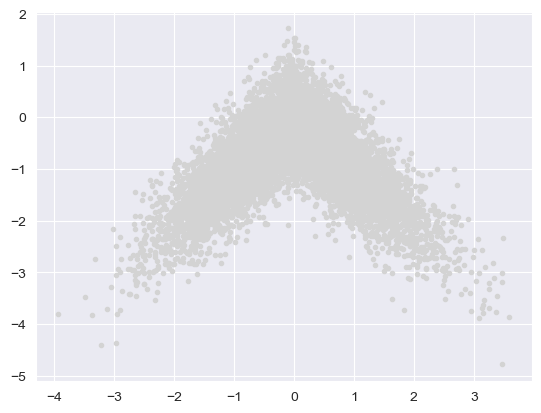

In [29]:
np.random.seed(7209)

N = 10_000  # sample size
x = np.random.normal(size=N)  # Generate x from a normal distribution
arg_sort_x = np.argsort(x)  # Sort x (for plotting purposes)
y = np.empty_like(x)  # Pre-allocate the output (dependent variable y)

b1 = 1.  # The slope for the first half of the domain
b2 = -1.  # The slope for the second half of the domain

# Generate the deterministic part of the output
# Here, we split the domain in two halves at 0 exactly:
y[x < 0.] = x[x < 0.]*b1
y[x >= 0.] = x[x >= 0.]*b2

# Add some noise to the output
y += np.random.normal(scale=0.5, size=N)

# Plot the data:
plt.scatter(x[arg_sort_x], y[arg_sort_x], color='#D3D3D3', marker='.')
plt.show()

The plot above shows the generated data. As we can see, the relationship between `x` and `y` is not linear in general,
however, it can be well approximated by linear models locally (within the two halves of the domain that we defined before).

## Pre-trained Linear Models

To make this setup more equivalent to the polygenic score (PGS) setting, let's assume that we are given access to a number 
of pre-trained linear models. Let's further assume that, similar to GWAS/PGS settings, those models were pre-trained on 
different subsets or domains of the data. To do that, we will implement the following procedure:

1. Split the data into two halves (choose splitting point randomly from a uniform between -1 and 1).
2. Train a linear model on each half of the data.
3. To make things interesting, we'll include a bunch of random linear models as well that are unrelated to the data.

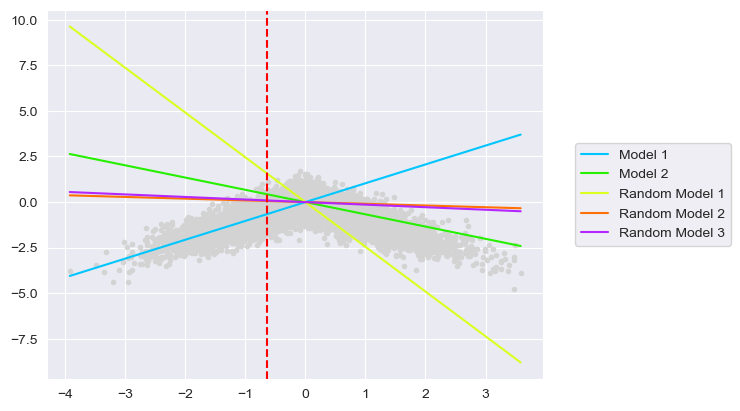

In [30]:
# Set the random seed:
np.random.seed(7209)

# Sample the split point:
split_point = np.random.uniform(-1, 1)

# Split x and y based on x's value with respect to the split point:
x1_mask = x < split_point  # Define a mask for points in the first half of the domain

# Extract points in the first half of the domain:
x1 = x[x1_mask]
y1 = y[x1_mask]

# Extract points in the second half of the domain:
x2 = x[~x1_mask]
y2 = y[~x1_mask]

# Train a linear model on each half of the domain:
b1_hat = np.cov(x1, y1, ddof=0)[0, 1] / np.var(x1)
b2_hat = np.cov(x2, y2, ddof=0)[0, 1] / np.var(x2)

# Generate some random linear models:
n_random_models = 3

# Generate random linear models:
random_b_hats = np.random.normal(scale=1, size=n_random_models)

# Put the beta hats together:
b_hats = np.concatenate([[b1_hat], [b2_hat], random_b_hats])

# Generate the predictions of the pre-trained models:
preds = x.reshape(-1, 1).dot(b_hats.reshape(1, -1))
# Generate the colors for the pre-trained models:
clrs = sns.color_palette('gist_ncar', n_colors=preds.shape[1])

# Plot the data and the pre-trained models:
plt.scatter(x[arg_sort_x], y[arg_sort_x], color='#D3D3D3', marker='.')

for i in range(preds.shape[1]):
    if i < 2:
        label = f"Model {i+1}"
    else:
        label = f"Random Model {i-1}"
    plt.plot(x[arg_sort_x], preds[arg_sort_x, i], color=clrs[i], label=label)

plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5))
# Plot the split point:
plt.axvline(split_point, color='r', linestyle='--', label='Training split point')
plt.show()

Note that in this case, because of the randomness in splitting the data, the split point is not exactly at 0. This makes 
the second model (Model 2) fit the data a bit poorly, nevertheless, it still fits the data better than Model 1 (or any of the 
other models for that matter!).

## Meta models

Now that we've generated the pre-trained models, we can use them to fit a meta model. A meta PRS model is a model that takes the 
predictions of simpler models and combines them in such a way that the combined model fits the data better than any of the
simpler models individually. Before we explore the meta PRS models, let's aggregate our data in a `PRSDataset` object:



In [31]:
# Aggregate the data + model predictions in a dataframe:

df = pd.DataFrame({'x': x, 'y': y})
model_names = []

for i in range(preds.shape[1]):
    
    if i < 2:
        model_name = f"Model_{i+1}"
    else:
        model_name = f"Random_Model_{i-1}"
    
    df[model_name] = preds[:, i]
    model_names.append(model_name)

df.head()

,x,y,Model_1,Model_2,Random_Model_1,Random_Model_2,Random_Model_3
0,-0.479875,0.544295,-0.495313,0.322259,1.177025,0.045127,0.067303
1,-0.497460,-0.592359,-0.513465,0.334069,1.220158,0.046781,0.069770
2,-0.004918,-0.602807,-0.005076,0.003303,0.012062,0.000462,0.000690
3,-0.538400,0.013082,-0.555722,0.361562,1.320574,0.050631,0.075512
4,0.557814,-1.081580,0.575760,-0.374599,-1.368193,-0.052456,-0.078234


In [32]:
# Create a PRSDataset object:

prs_data = PRSDataset(df, 
                      phenotype_col='y', # Specify the target column (equivalent to phenotype)
                      prs_cols=model_names, # Specify the column names containing pre-trained model predictions
                      covariates_cols='x') # Specify the column names containing the covariates (if any)

### MultiPRS

First, we will explore the MultiPRS model formulation, which takes the individual predictions of the pre-trained
models and combines them linearly to get the final prediction:

$$
y_{MultiPRS}(i) = \alpha_0 + \sum_{k=1}^{K} \hat{\beta}_k \hat{y}_k(i) 
$$

where $\hat{y}_k(i)$ is the prediction of the $k$-th pre-trained model for the $i$-th observation, and $\hat{\beta}_k$ is the
coefficient of the $k$-th pre-trained model. The coefficient $\alpha_0$ is the intercept of the meta model.

Here's how the MultiPRS model can be fit to the data using the `MultiPRS` class from the `baseline_models` module:

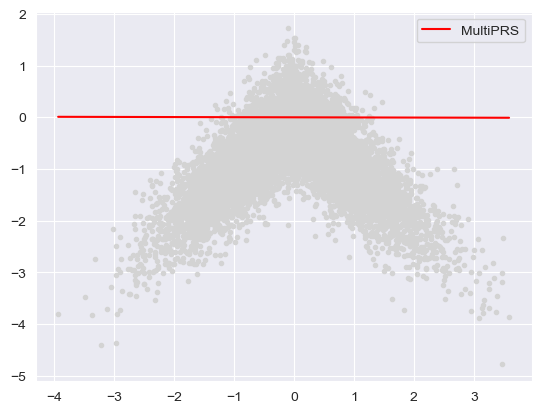

In [33]:
# Create the MultiPRS model:
multi_prs = MultiPRS(prs_data,
                     expert_cols=model_names, # Specify the column names containing pre-trained model predictions
                     covariates_cols='x')

# Fit the MultiPRS model:
multi_prs.fit()

# Visualize the fitted model predictions:
multi_prs_pred = multi_prs.predict()

# Plot the data and the pre-trained models:
plt.scatter(x[arg_sort_x], y[arg_sort_x], color='#D3D3D3', marker='.')
plt.plot(x[arg_sort_x], multi_prs_pred[arg_sort_x], color='r', label='MultiPRS')
plt.legend()
plt.show()

As we can see, the MultiPRS model struggles to fit this heterogeneous data well. This is because it has to minimize the error 
with a single linear model across the entire domain. This is where the strengths of the Mixture of Experts (MoE) model come to shine.

### Mixture of Experts (MoE)

The Mixture of Experts (MoE) model is a more flexible meta PRS model that can fit the data better than the MultiPRS model. The MoE model formulates the prediction as a weighted sum of the predictions of the pre-trained models, where the weights are determined by a gating network:

$$
y_{MoE}(i) = \sum_{k=1}^{K} g_k(x_i) \hat{y}_k(i)
$$

Here, $g_k(x_i)$ is the output of the gating model for the $i$-th observation and the $k$-th pre-trained model. In our case, the gating model is a linear model that takes the covariates as input and outputs the weights for the pre-trained models (i.e. it performs the equivalent of softmax regression). The weights are then used to combine the predictions of the pre-trained models to get the final prediction. The important thing to realize here is that the weights of the gating model depend on the input, which allows the MoE to select the best model for each input domain.

Here's how the MoE model can be fit to the data using the `MoEPRS` class from the `moe` module:

  0%|          | 0/1000 [00:00<?, ?it/s]

Converged at iteration 66


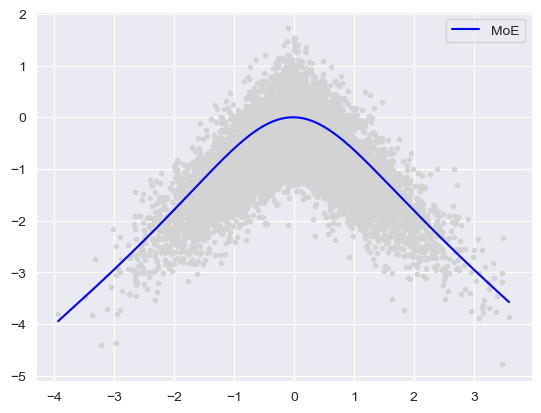

In [34]:
# Create the MultiPRS model:
moe_model = MoEPRS(prs_data,
                   expert_cols=model_names, # Specify the column names containing pre-trained model predictions
                   gate_input_cols='x', # Specify the input columns for the gating model
                   expert_add_intercept=False,
                   gate_add_intercept=True)

# Fit the MultiPRS model:
moe_model.fit()

# Visualize the fitted model predictions:
moe_pred = moe_model.predict()

# Plot the data and the pre-trained models:
plt.scatter(x[arg_sort_x], y[arg_sort_x], color='#D3D3D3', marker='.')
plt.plot(x[arg_sort_x], moe_pred[arg_sort_x], color='b', label='MoE')
plt.legend()
plt.show()

That's a lot better! The MoE model is able to fit the data much better by selectively using the pre-trained models in the regions 
where they fit the data well. To see what the gating model is doing, let's plot its weights as a function of the input variable `x`:

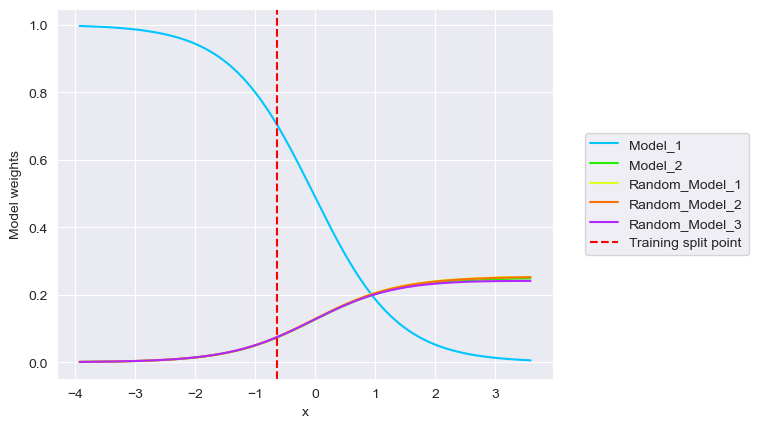

In [35]:
# Get the gating model weights:
gate_weights = moe_model.predict_proba()

# Plot the weights as a function of x:
for i in range(gate_weights.shape[1]):
    plt.plot(x[arg_sort_x], gate_weights[arg_sort_x, i], color=clrs[i], label=model_names[i])
    
# Plot the split point:
plt.axvline(split_point, color='r', linestyle='--', label='Training split point')

plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5))
plt.ylabel("Model weights")
plt.xlabel("x")
plt.show()

What we see here is that the gating model is correctly assigning high weights to Model 1 in the first half of the domain. However, 
for the second domain, because Model 2 does not fit the data perfectly, it tries to select a blend of the correct model (Model 2) with 
some of the random models in order to fit the data as well as possible.